In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
#sns.set(font_scale=2)

In [2]:
# Parent directory for the results of this run
group_results_directory = '/data/jpetrie/MEOPAR/SalishSea/results/nampisprod_params_june_7/' + '/'
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'
mesh_mask_file = 'mesh_mask.nc'
individual_directories = []
param_vals = []
param_name = "nampisprod_zz_rate_r_diat"

for file in os.listdir(group_results_directory):
    if os.path.isfile(group_results_directory + file + '/' + tracer_file):
        if file.startswith(param_name):
            val = float(file.split(param_name + "_")[1])
            individual_directories.append(file)
            param_vals.append(val)

tracer_datasets = [xr.open_dataset(group_results_directory + '/' + file +'/' + tracer_file) for file in individual_directories]
dataset_dict = dict(zip(param_vals, tracer_datasets))

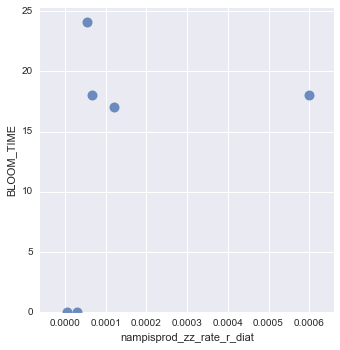

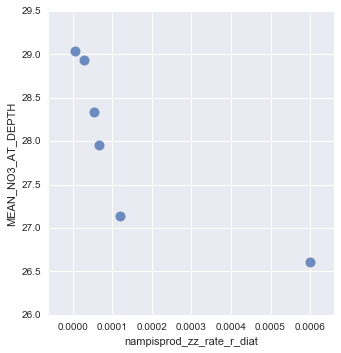

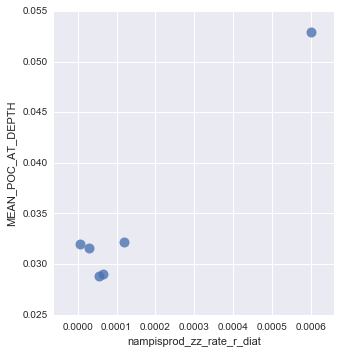

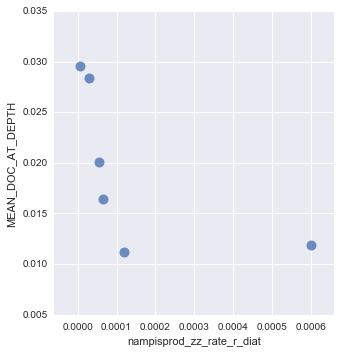

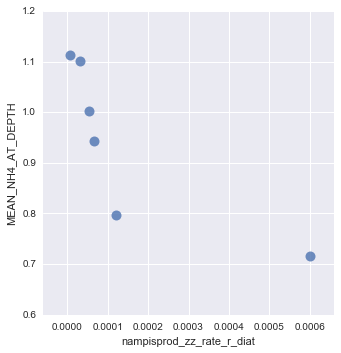

In [3]:
depths = dataset_dict[param_vals[0]].deptht.values

min_depth_index = np.argmax(depths > 150)
max_depth_index = len(depths)

#for param in param_vals:
t = np.array([float(x) for x in dataset_dict[param_vals[0]].time_centered.values])   
days = (t[:] - t[0])/10**9/3600/24

min_day_index = np.argmax(days > 30)
max_day_index = len(days)

mesh_mask = xr.open_dataset(group_results_directory + individual_directories[0] + '/' + mesh_mask_file)
grid_heights = np.array(mesh_mask['e3t_1d'][0])

param_metrics = pd.DataFrame({param_name:param_vals})

plot_tracers = ['NO3', 'POC', 'DOC', 'NH4']

for param in param_vals:
    for tracer in plot_tracers:
        tracer_quantity_array = ((dataset_dict[param][tracer].values)*(grid_heights.reshape((1,40,1,1))))
        total_tracer_at_depth = tracer_quantity_array[min_day_index:max_day_index, min_depth_index:max_depth_index,:,:].sum()
        mean_tracer = total_tracer_at_depth/sum(grid_heights[min_depth_index:max_depth_index])/(max_day_index - min_day_index)/15
        param_metrics.loc[(param_metrics[param_name] == param), "MEAN_"+tracer+ "_AT_DEPTH"] = mean_tracer
    phy2_qunatity_array = ((dataset_dict[param]["PHY2"].values)*(grid_heights.reshape((1,40,1,1))))
    phy2_qunatity_array.sum((0,3)).shape
    total_phy2 = phy2_qunatity_array.sum((1,2,3))
    # Bloom time is defined as the day of maximum PHY2 population. For simulation time ranges with multiple 
    # blooms this should be redefined
    param_metrics.loc[(param_metrics[param_name] == param), "BLOOM_TIME"] = days[np.argmax(total_phy2)]



p = sns.lmplot(param_name, 'BLOOM_TIME',data=param_metrics,fit_reg=False, scatter_kws={"marker": "D",  "s": 100})
plt.xlim(0 - max(param_vals)*0.1,max(param_vals)*1.1)
plt.ylim(0.95*min(param_metrics['BLOOM_TIME']),max(param_metrics['BLOOM_TIME'])*1.05)    
for tracer in plot_tracers:
    p = sns.lmplot(param_name, 'MEAN_'+tracer + "_AT_DEPTH",data=param_metrics,fit_reg=False, scatter_kws={"marker": "D",  "s": 100})
    plt.xlim(0 - max(param_vals)*0.1,max(param_vals)*1.1)

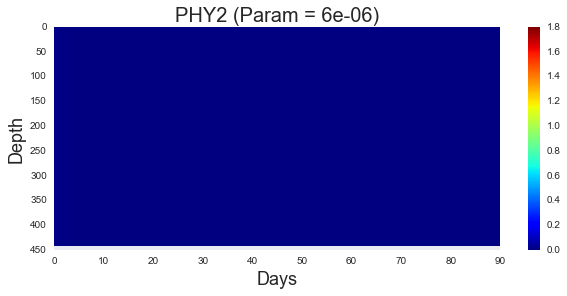

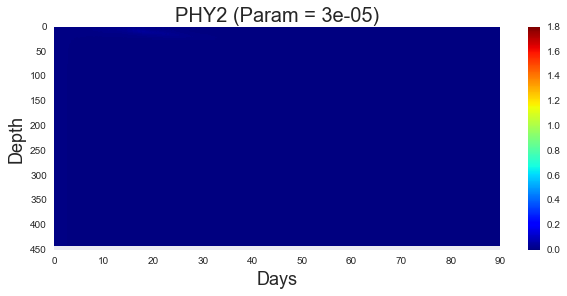

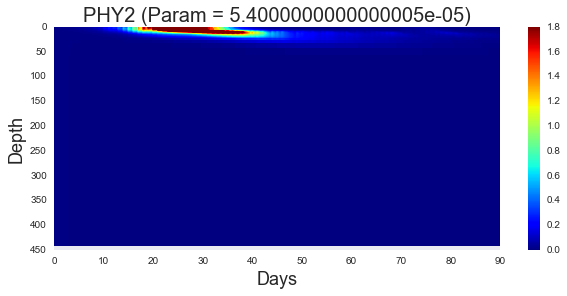

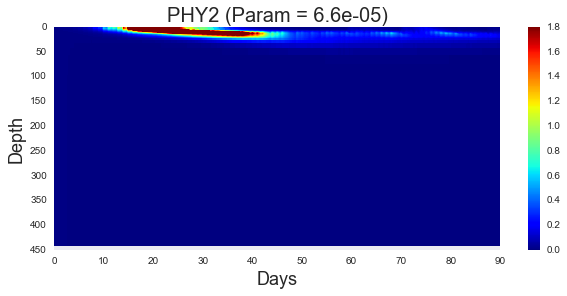

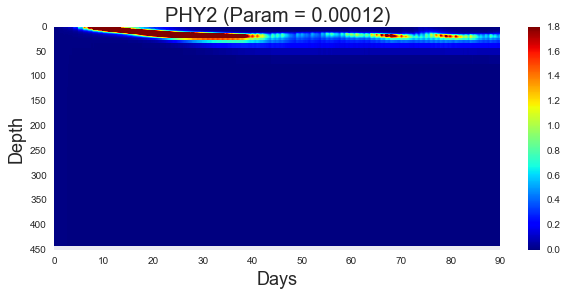

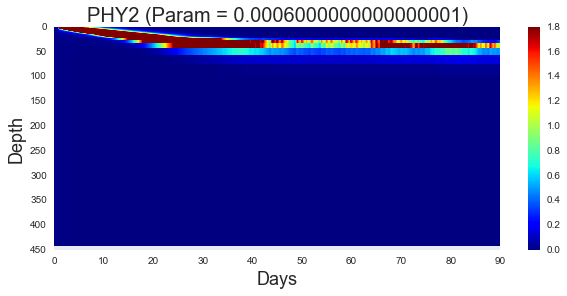

In [4]:
# Plot depth/time/DON heatmap for each value of alpha
tracer = "PHY2"


keys = (list(dataset_dict.keys()))
keys.sort()

for param_val in keys:
    z = dataset_dict[param_val].deptht.values
    t= np.array([float(x) for x in dataset_dict[param_val].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[param_val][tracer].values[:,:,2,2].T, vmin = 0,vmax = 1.8)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title(tracer +  " (Param = " + str(param_val)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

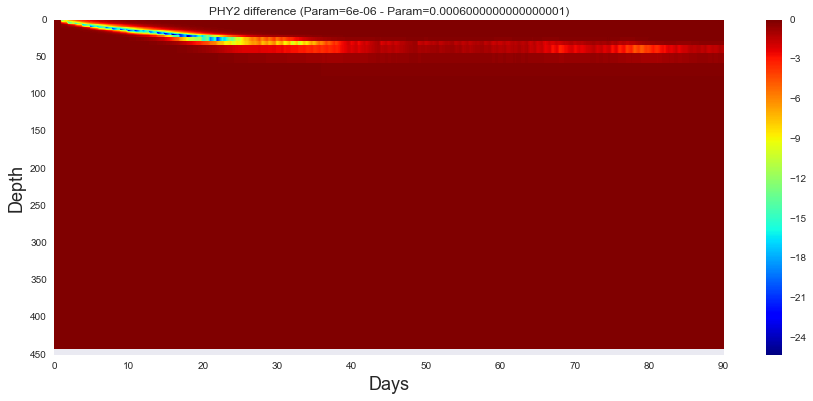

In [5]:
# Plot the difference in DON concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)
mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1][tracer].values[:,:,2,2].T - dataset_dict[param_2][tracer].values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title(tracer + " difference (Param=" + str(param_1) + " - Param=" +str(param_2)+ ")")

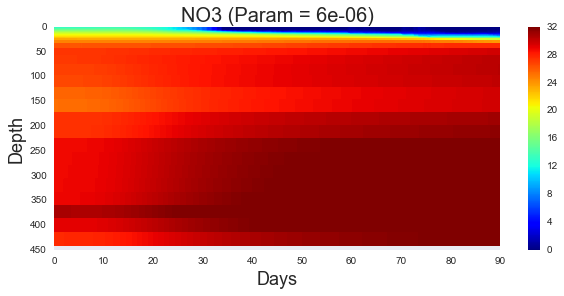

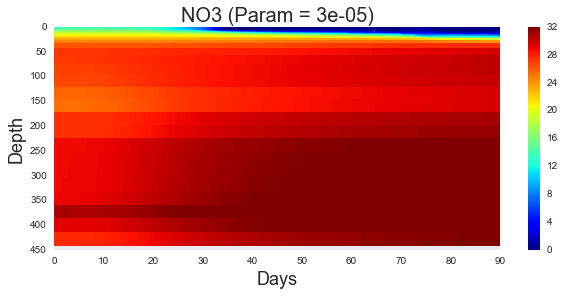

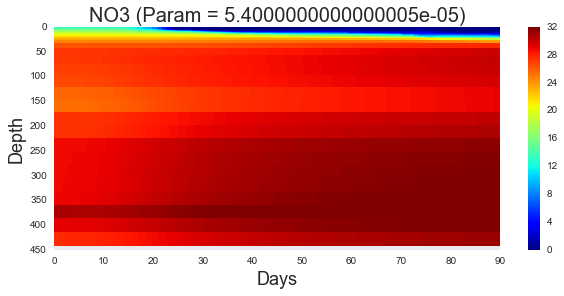

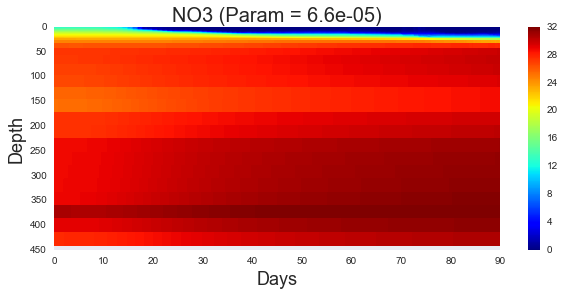

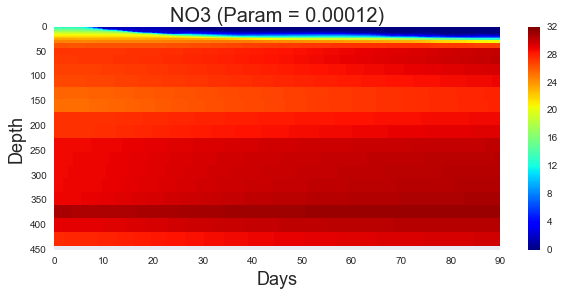

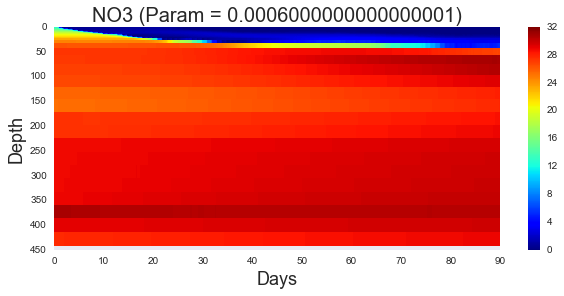

In [6]:
# Plot depth/time/NO3 heatmap for each value
tracer = "NO3"


for param_val in keys:
    z = dataset_dict[param_val].deptht.values
    t= np.array([float(x) for x in dataset_dict[param_val].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[param_val][tracer].values[:,:,2,2].T, vmin = 0, vmax = 32)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title(tracer + " (Param = " + str(param_val)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

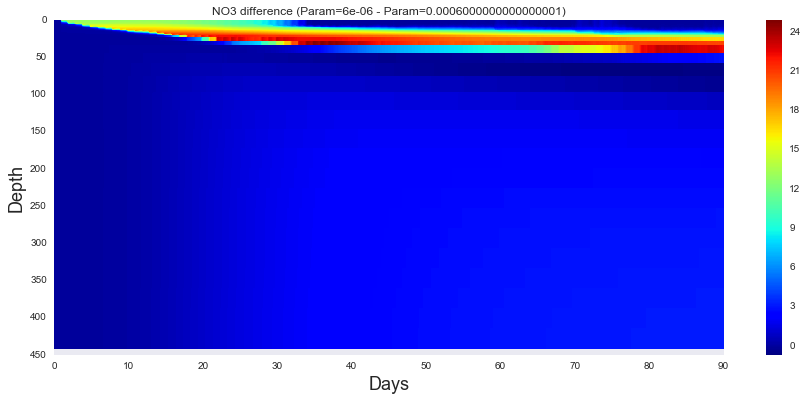

In [7]:
# Plot the difference in NO3 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1][tracer].values[:,:,2,2].T - dataset_dict[param_2][tracer].values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title(tracer + " difference (Param=" + str(param_1) + " - Param=" +str(param_2)+ ")")

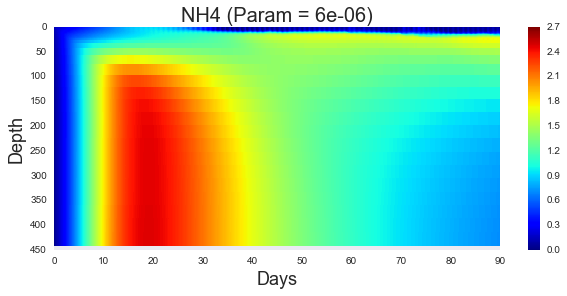

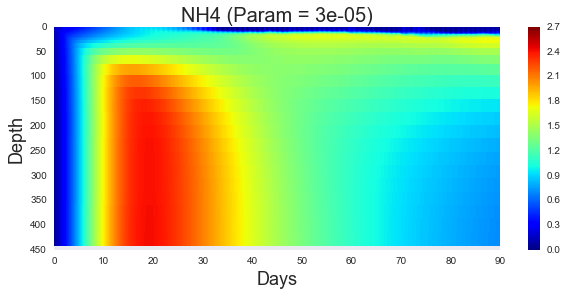

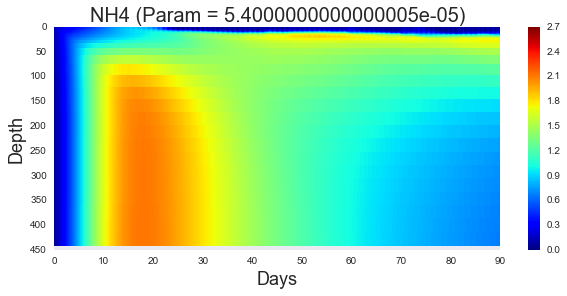

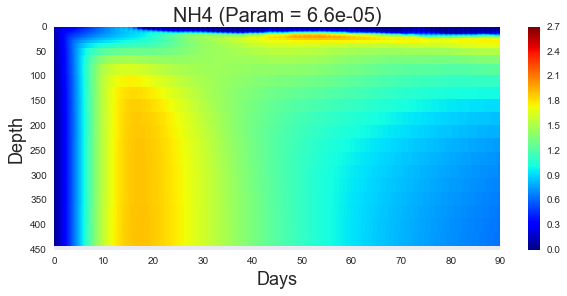

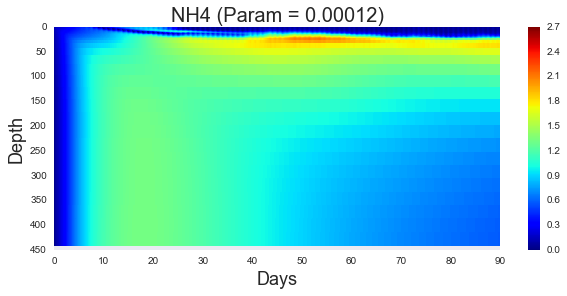

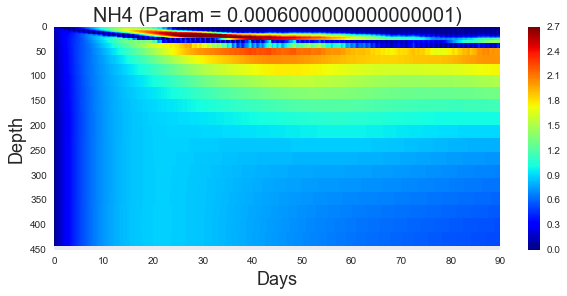

In [8]:
# Plot depth/time/DON heatmap for each value of alpha
tracer = "NH4"


keys = (list(dataset_dict.keys()))
keys.sort()

for param_val in keys:
    z = dataset_dict[param_val].deptht.values
    t= np.array([float(x) for x in dataset_dict[param_val].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[param_val][tracer].values[:,:,2,2].T, vmin = 0,vmax = 2.7)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title(tracer +  " (Param = " + str(param_val)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

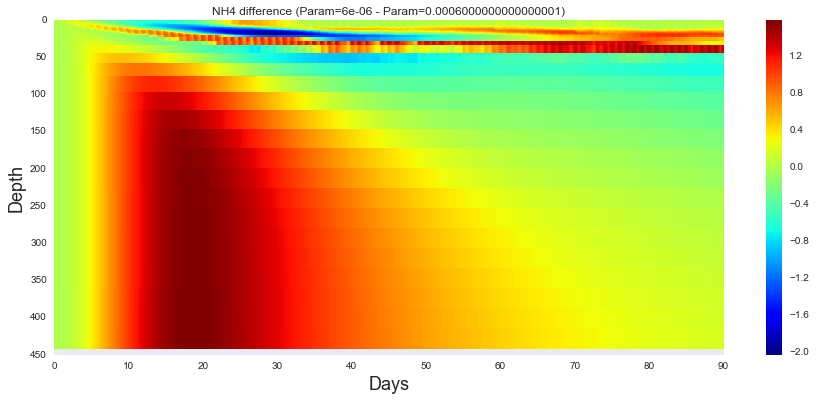

In [9]:
# Plot the difference in NO3 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1][tracer].values[:,:,2,2].T - dataset_dict[param_2][tracer].values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title(tracer + " difference (Param=" + str(param_1) + " - Param=" +str(param_2)+ ")")

In [10]:
# Convert list of xarrays to a single pandas dataframe. Easier to manipulate and plot
dataframe_list = []
for param_val in keys:
    df = dataset_dict[param_val].to_dataframe().query('x == 2 and y == 2 and axis_nbounds == 0')
    df[param_name] = param_val
    dataframe_list.append(df)

df_subset = pd.concat(dataframe_list)

df_subset.reset_index(inplace=True) # Get rid of that multiindex madness

In [11]:
plot_vars = [ 'DOC','MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi']

[   0.5000003    15.63428783  199.57304382]


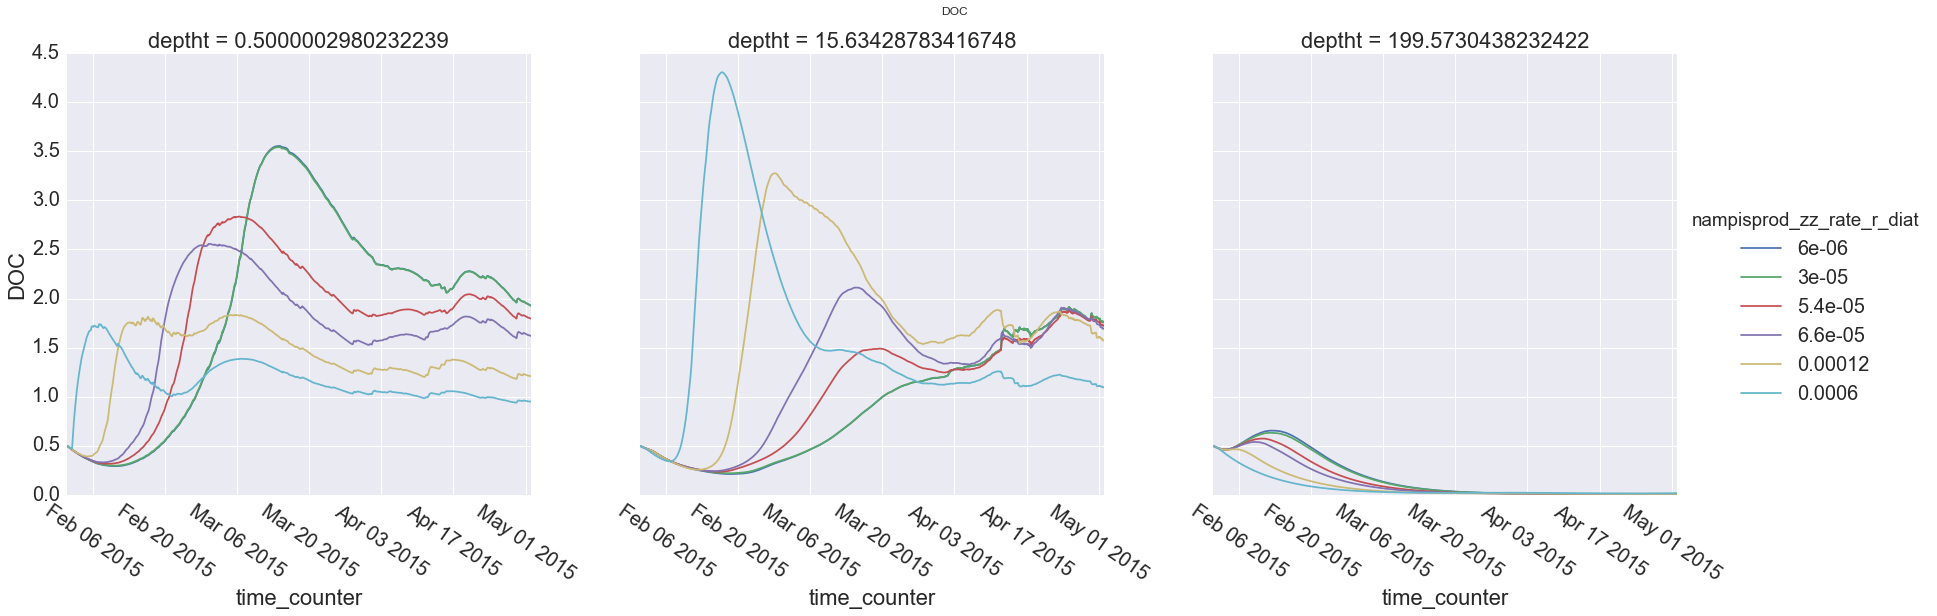

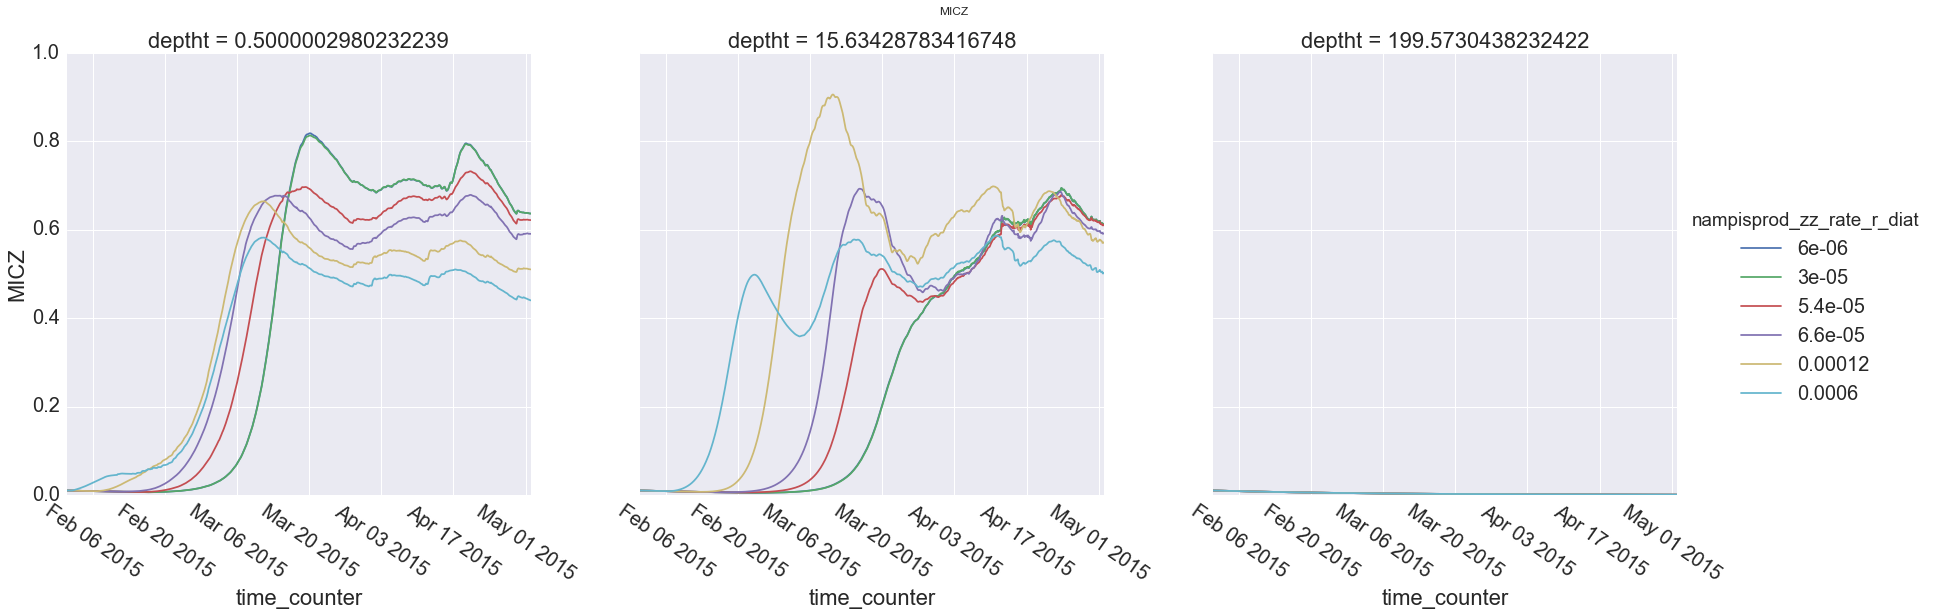

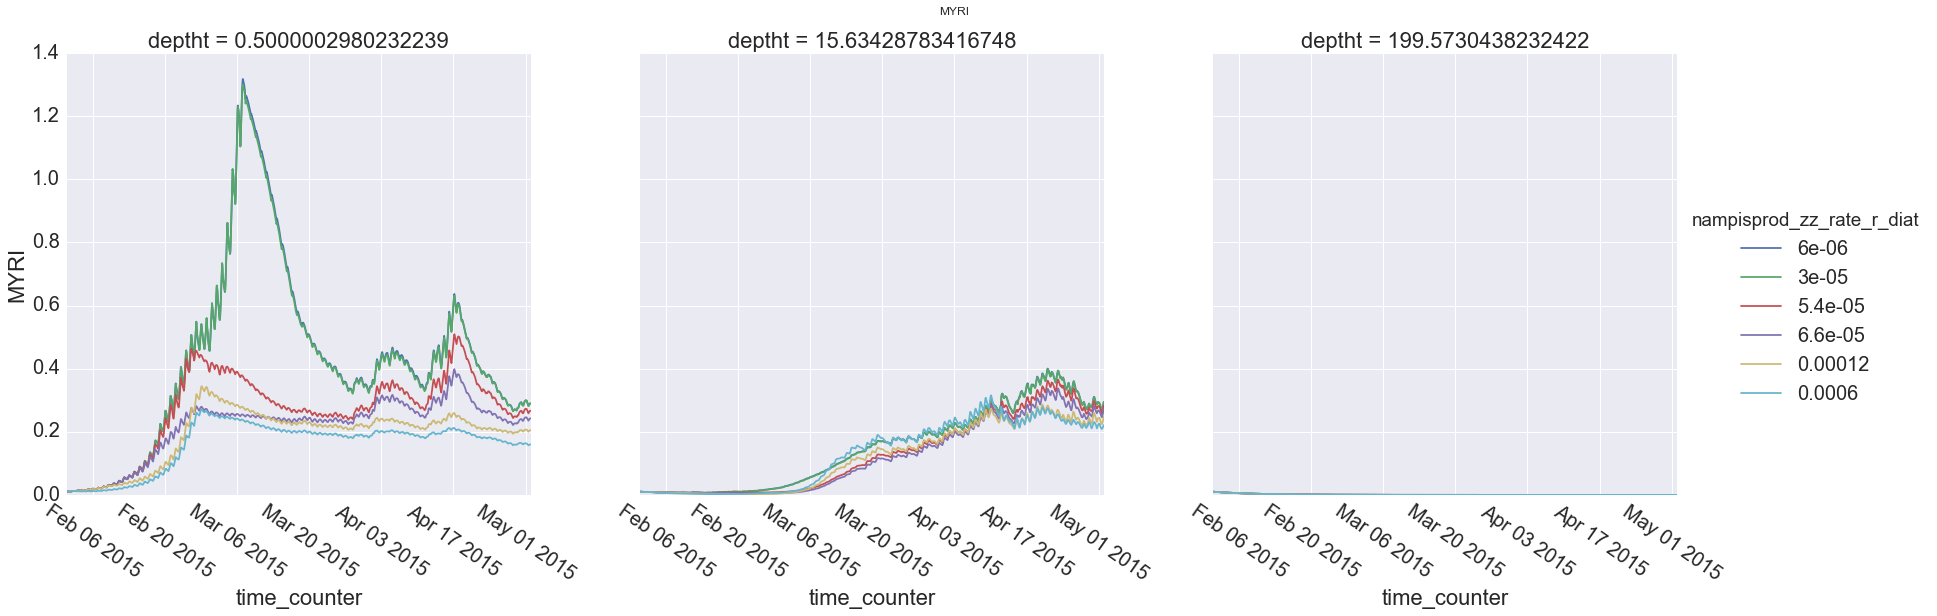

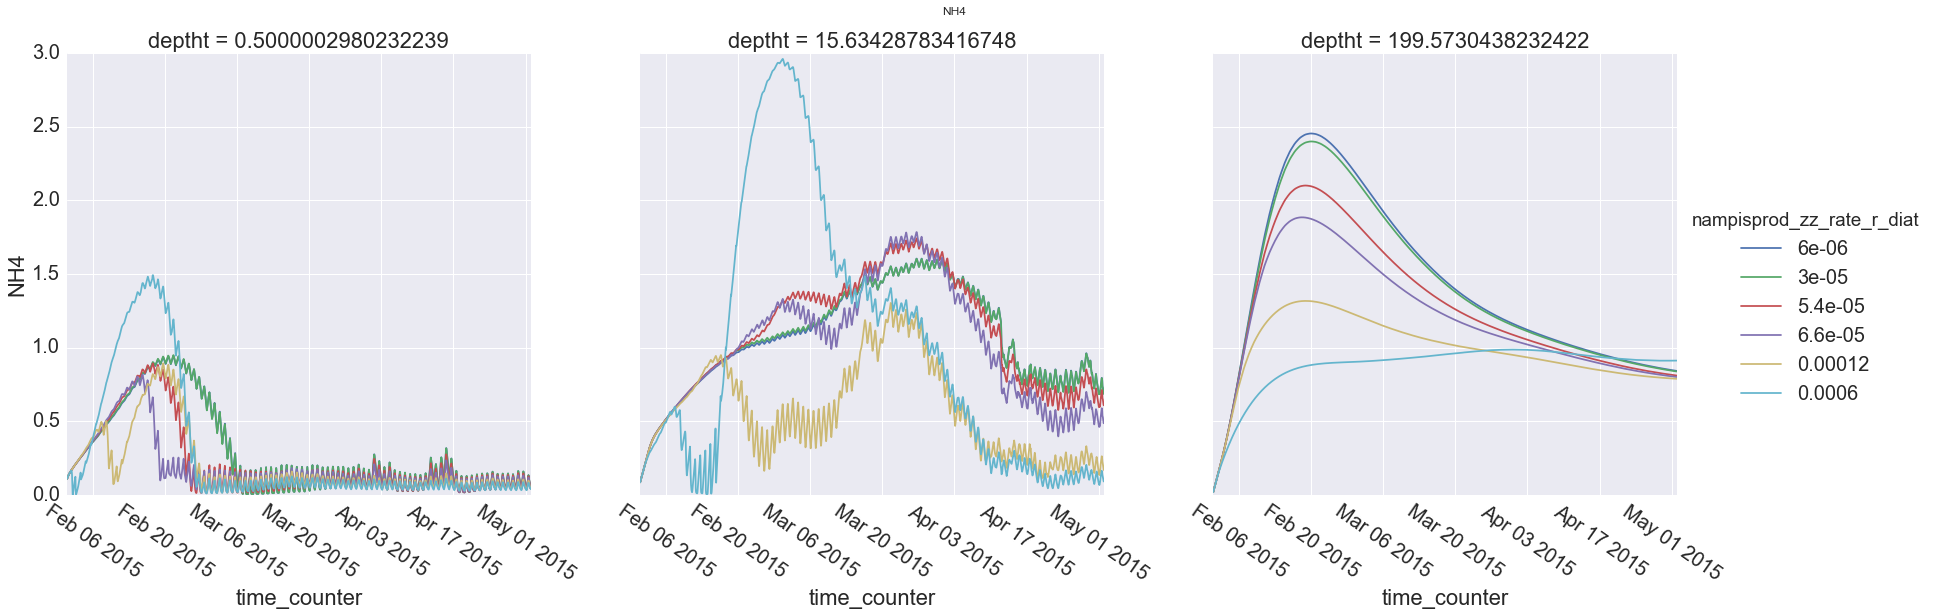

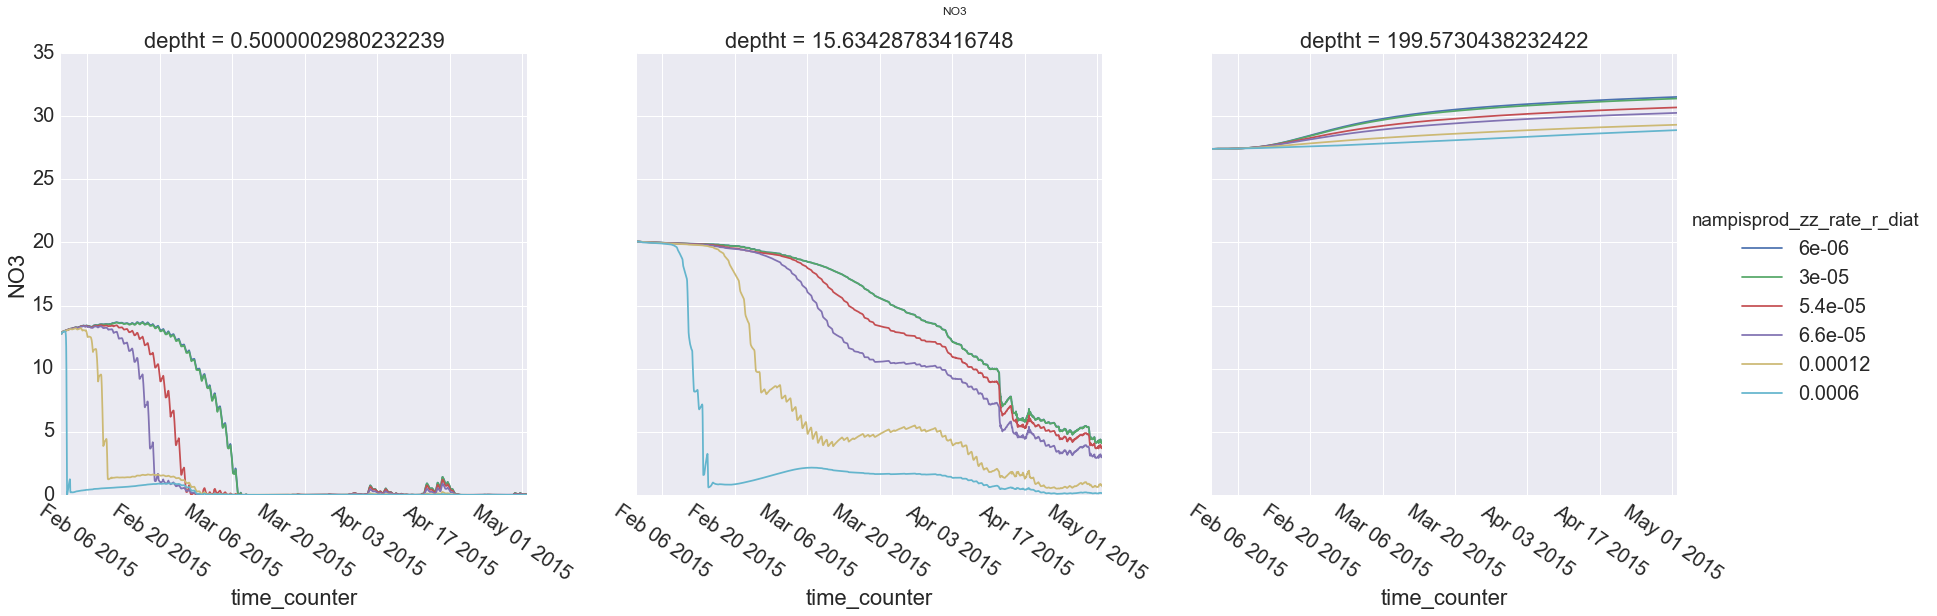

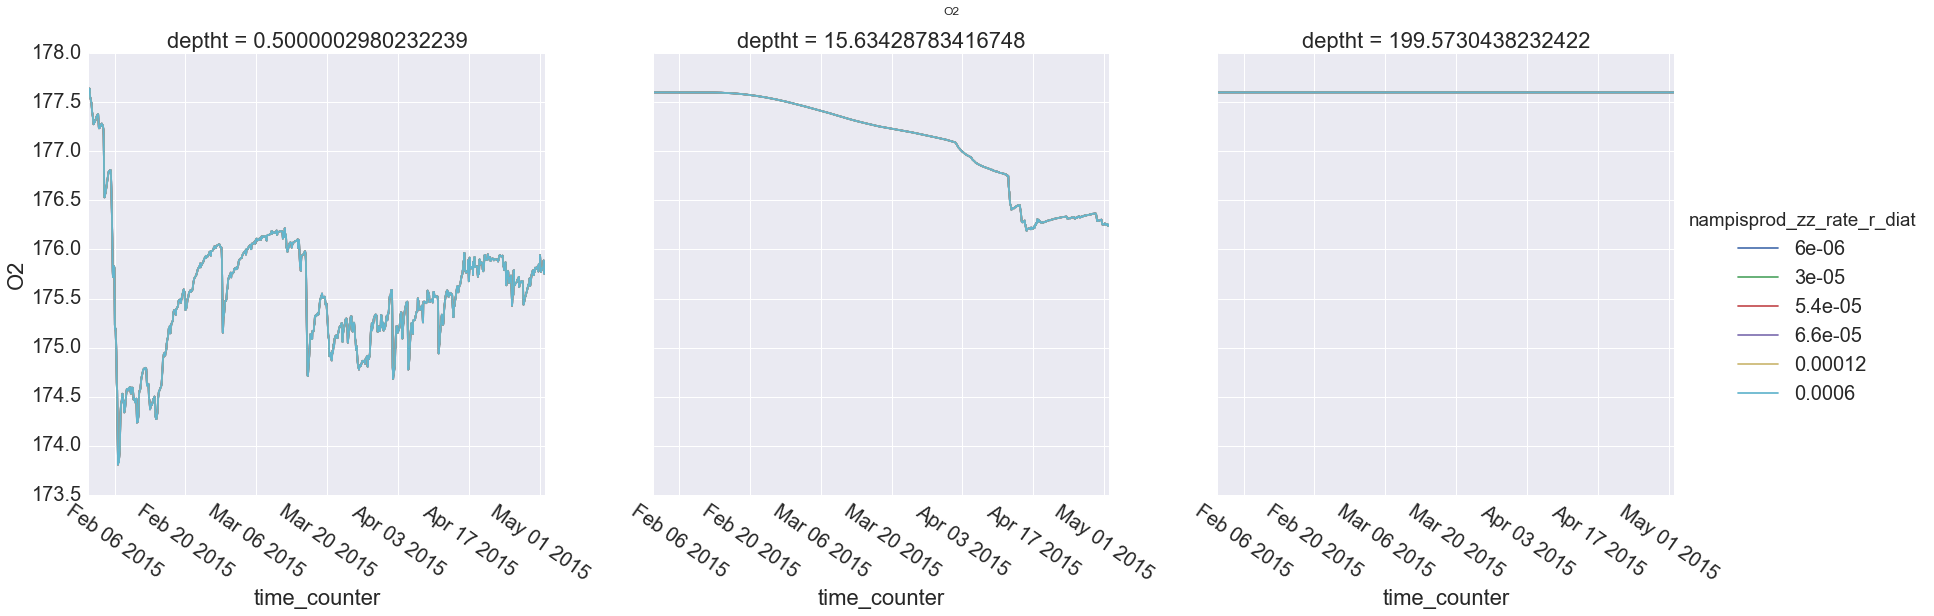

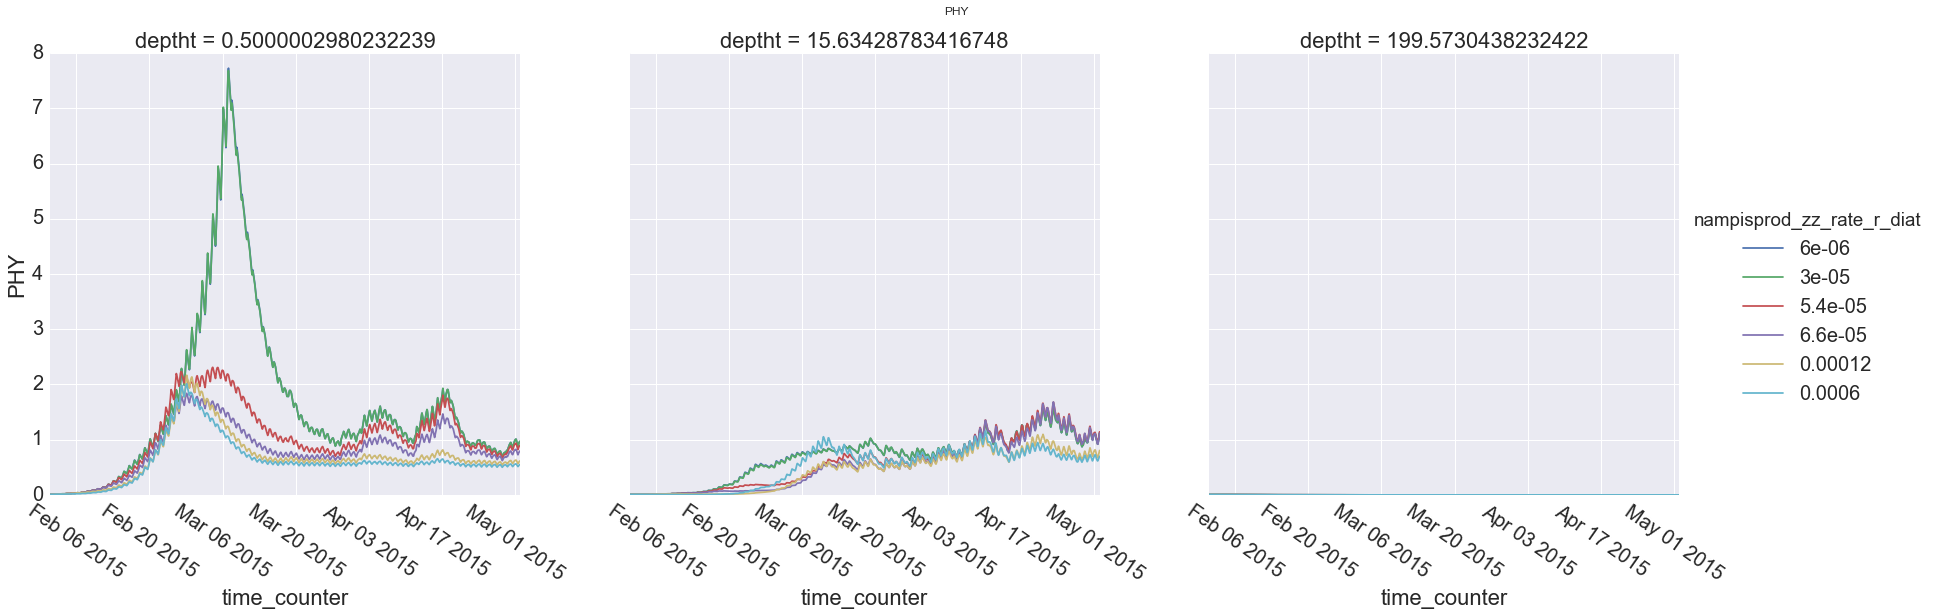

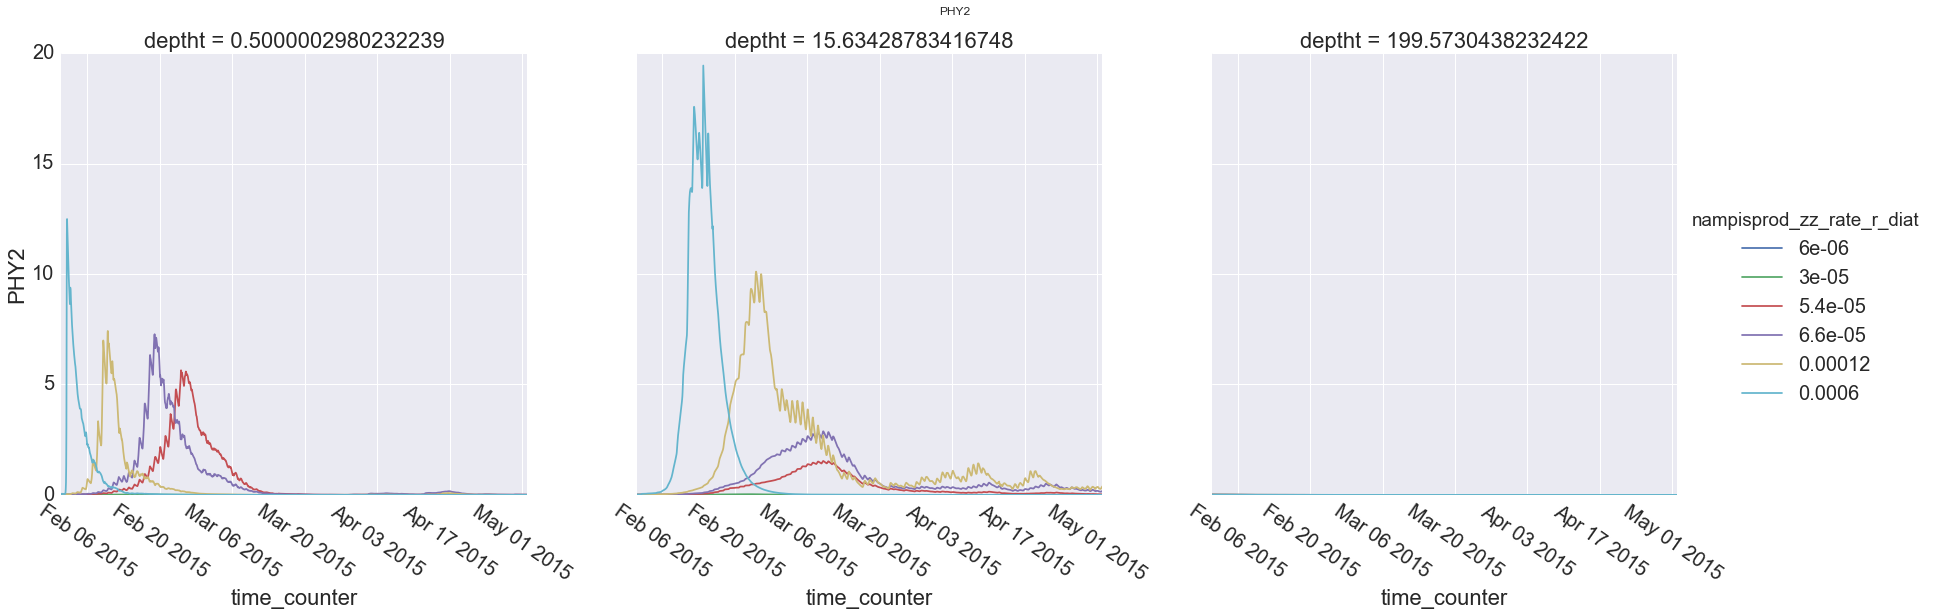

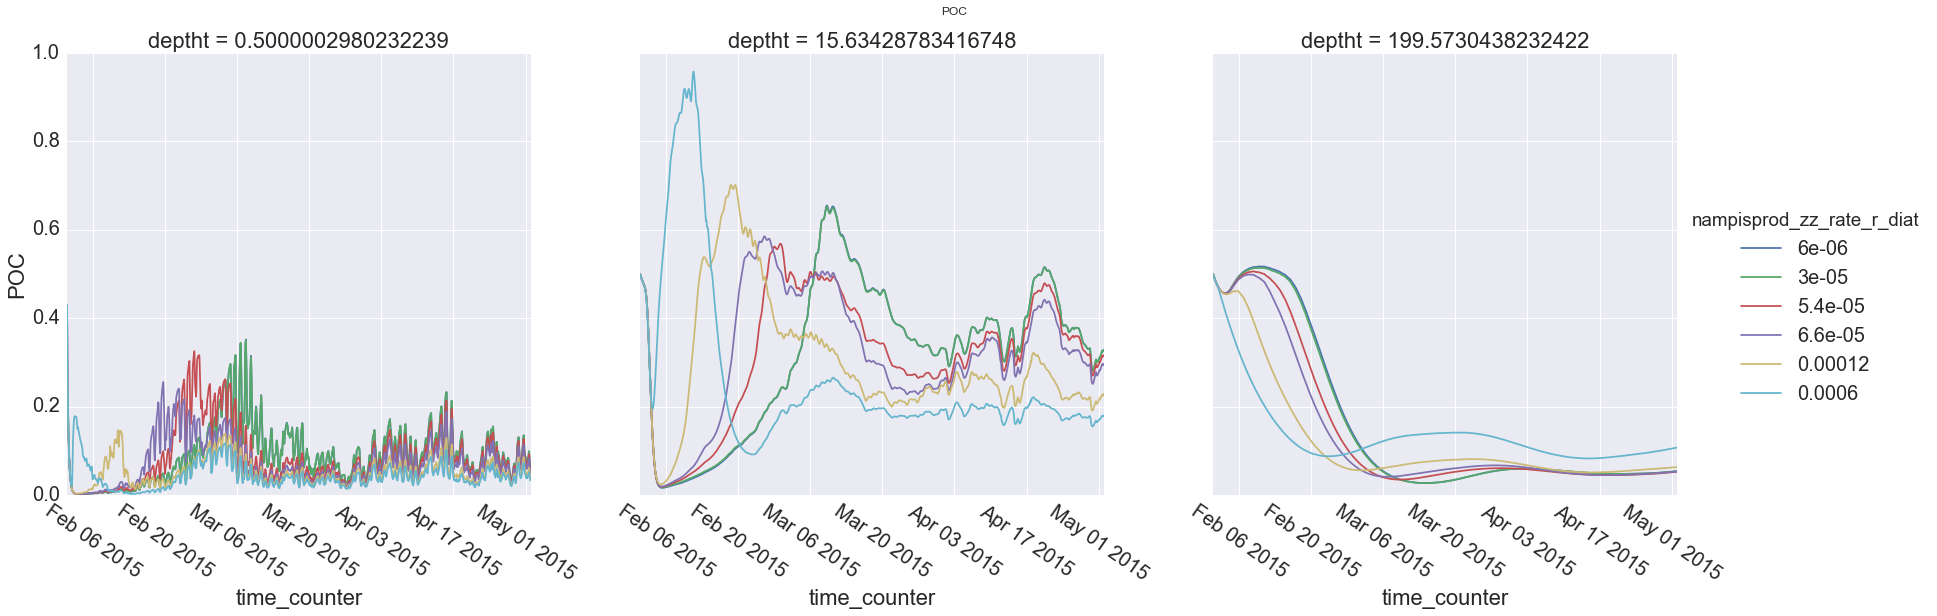

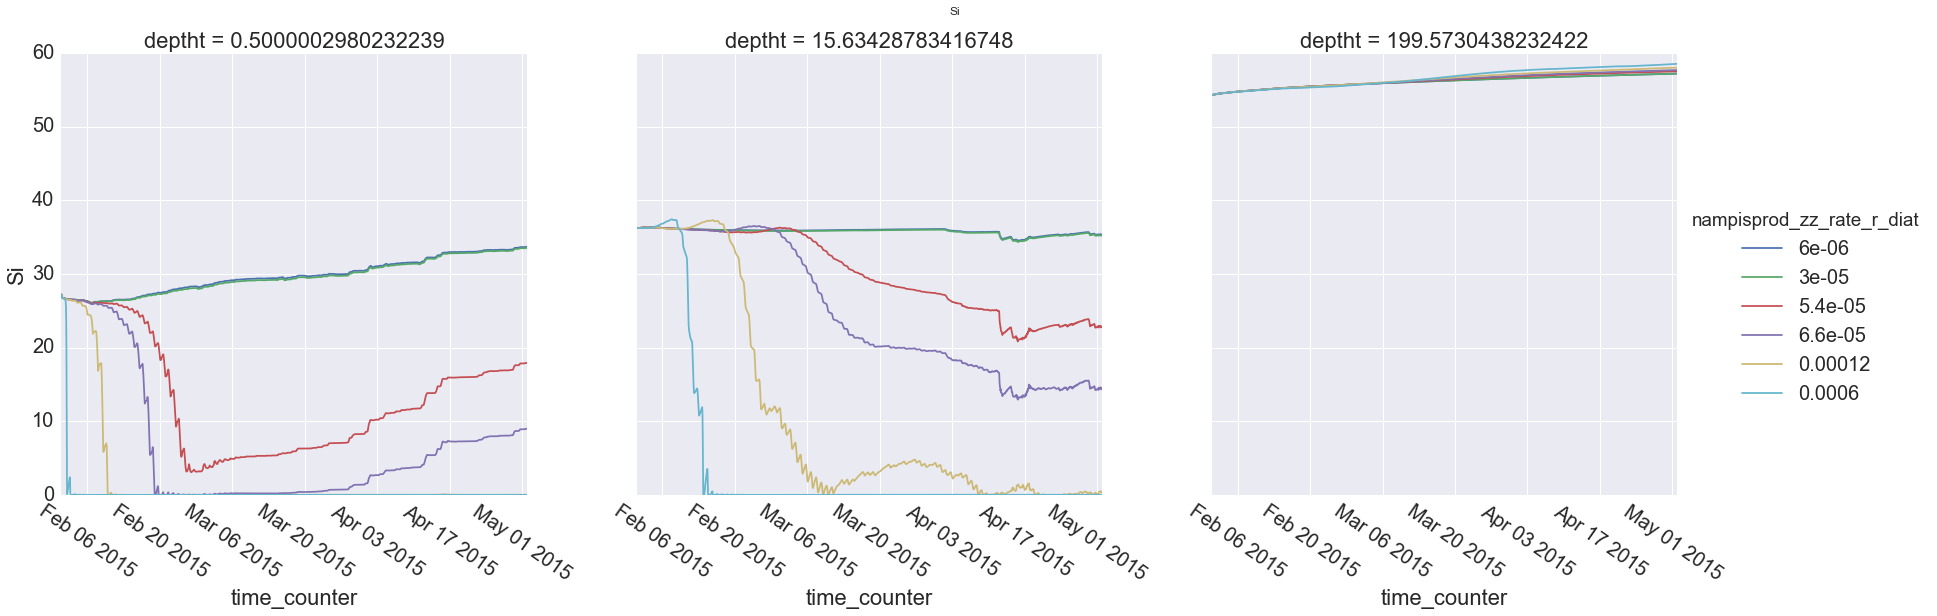

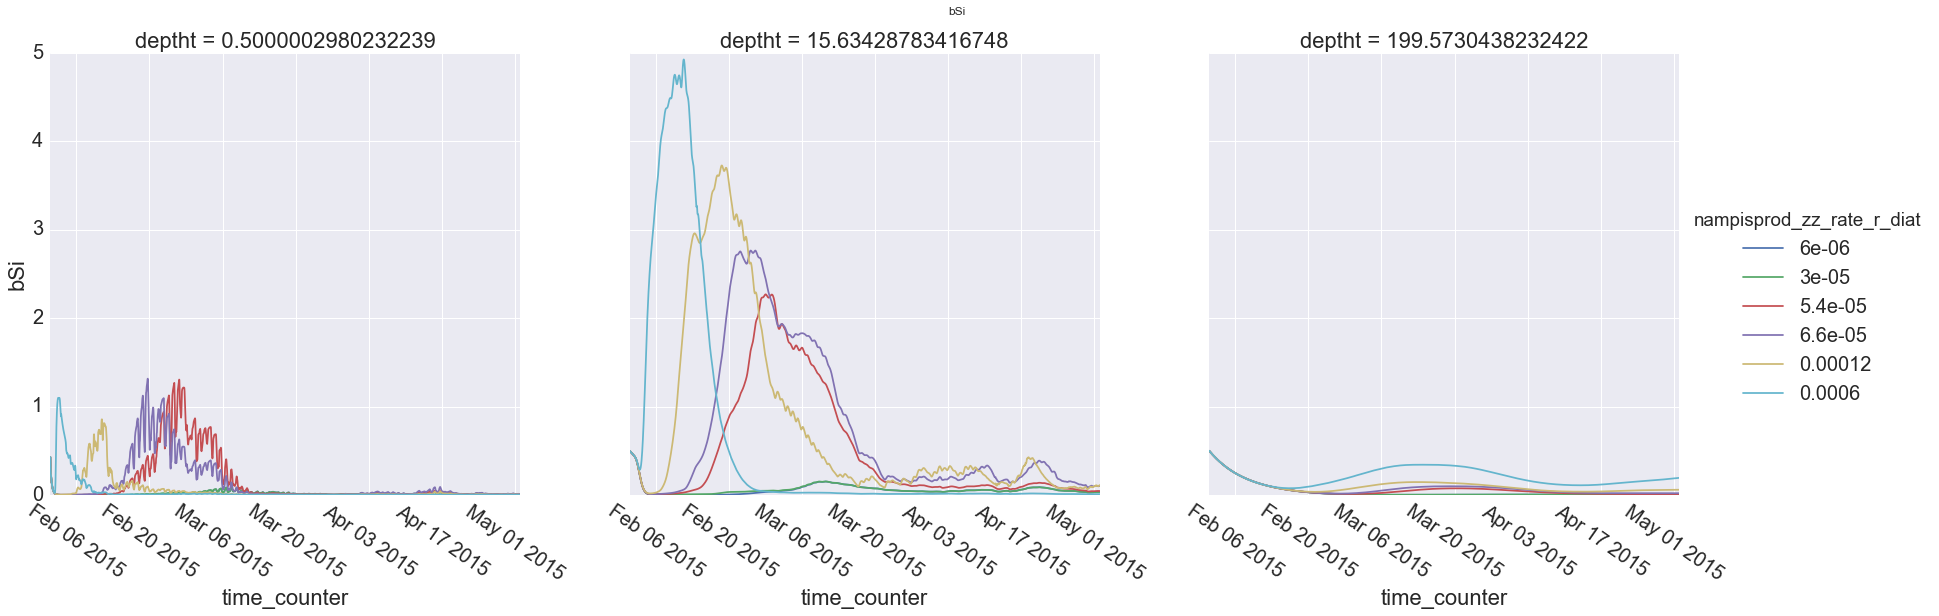

In [12]:
sns.set(font_scale = 2)
depth_vals = (df_subset['deptht'].unique())[0:40:15]

print(depth_vals)
for var in plot_vars:
    fg = sns.FacetGrid(data=df_subset.query("deptht in @depth_vals"), hue=param_name,col = "deptht",size =8)
    fg.map(plt.plot, 'time_counter', var).add_legend()
    fg.set_xticklabels(rotation=-35)
    plt.subplots_adjust(top=0.9)
    fg.fig.suptitle(var)
sns.set(font_scale = 1)